# Homework 2 - Generalized Hough Transform

## Theory

< Insert your answers here >

## Programming

Find object in an image using a template:  
![title](data/template.jpg)
![title](data/query.jpg)

In [27]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import cv2
import utils
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import json

def nonMaxSuprression(img, d=5):
    """
    Given an image set all values to 0 that are not
    the maximum in its (2d+1,2d+1)-window

    Parameters
    ----------
    img : ndarray
        an image
    d : int
        for each pixels consider the surrounding (2d+1,2d+1)-window

    Returns
    -------
    result : ndarray

    """
    rows,cols = img.shape
    result = np.zeros((rows,cols))
    # TODO
    # iterate over pixels
    for r in range(rows):
        for c in range(cols):
            y_axis_lowest = max(0, r-d)
            x_axis_lowest = max(0, c-d)

            y_axis_highest = min(rows, r+d)
            x_axis_highest = min(cols, c+d)

            maximum = img[y_axis_lowest:y_axis_highest, x_axis_lowest:x_axis_highest].max()

            if img[r,c] == maximum:
                result[r,c] = maximum
        

    return result
    # iterate over (2d+1,2d+1) neighborhood window
    # supress non-maxima to 0
    # store results in new array
    
    return result

def calcBinaryMask(img, thresh = 0.3):
    """
    Compute the gradient of an image and compute a binary mask
    based on the threshold. Corresponds to O^B in the slides.

    Parameters
    ----------
    img : ndarray
        an image
    thresh : float
        A threshold value. The default is 0.3.

    Returns
    -------
    binary : ndarray
        A binary image.

    """

    # TODO: 
    # -compute gradients
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)

    grad = sobel_x + 1.0j*sobel_y

    grad_abs_val = np.absolute(grad)

    magnitude = np.where(grad_abs_val > thresh * grad_abs_val.max(), 1, 0)

    
    
    # -threshold gradients 
    # -return binary mask


    return np.zeros_like(magnitude)


def correlation(img, template):
    """
    Compute a correlation of gradients between an image and a template.
    
    Note:
    You should use the formula in the slides using the fourier transform.
    Then you are guaranteed to succeed.
    
    However, you can also compute the correlation directly. 
    The resulting image must have high positive values at positions
    with high correlation.

    Parameters
    ----------
    img : ndarray
        a grayscale image
    template : ndarray
        a grayscale image of the template

    Returns
    -------
    ndarray
        an image containing the correlation between image and template gradients.
    """

   
    # TODO:
    # -compute gradient of the image

    sobel_x_img = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y_img = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)

    grad_img = sobel_x_img + 1.0j*sobel_y_img


    # -compute gradient of the template
    sobel_x_templ = cv2.Sobel(template, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y_templ = cv2.Sobel(template, cv2.CV_64F, 0, 1, ksize=5)

    grad_templ = sobel_x_templ + 1.0j*sobel_y_templ

 
    # -copy template gradient into larger frame

    fr = np.zeros_like(grad_img.copy())
    height, width = grad_templ.shape
    fr[:height, :width] = grad_templ


    fr2 = np.zeros_like(img.copy())
    fr2[:height, :width] = template



    # -apply a circular shift so the center of the original template is in the

    shifted_fr = np.zeros_like(fr) 
    shifted_fr2 = np.zeros_like(fr2)
    height,width = fr.shape
    shifted_fr[:-height//2,:-width//2] = fr[height //2:, width //2:]
    shifted_fr[:-height//2,-width//2:] = fr[height//2:,:width //2]
    shifted_fr[-height//2:,:-width//2] = fr[:height//2,width//2:]
    shifted_fr[-height//2:,-width//2:] = fr[:height//2,:width//2]

    height,width = fr2.shape
    shifted_fr2[:-height//2,:-width//2] = fr2[height //2:, width //2:]
    shifted_fr2[:-height//2,-width//2:] = fr2[height//2:,:width //2]
    shifted_fr2[-height//2:,:-width//2] = fr2[:height//2,width//2:]
    shifted_fr2[-height//2:,-width//2:] = fr2[:height//2,:width//2]
    #   upper left corner
    # -normalize template
    temp_i = fr / ((np.abs(shifted_fr)).sum())
    temp_b = calcBinaryMask(shifted_fr2, thresh=0.3)
    res = temp_i * temp_b
    # -compute correlation
    dft_i = np.fft.fft2(grad_img)
    dft_t = np.fft.fft2(res)

    correlation = np.abs((np.fft.ifft2(dft_i*(dft_t.conj()))).real)

    return correlation



def GeneralizedHoughTransform(img, template, angles, scales):
    """
    Compute the generalized hough transform. Given an image and a template.
    
    Parameters
    ----------
    img : ndarray
        A query image
    template : ndarray
        a template image
    angles : list[float]
        A list of angles provided in degrees
    scales : list[float]
        A list of scaling factors

    Returns
    -------
    hough_table : list[(correlation, angle, scaling)]
        The resulting hough table is a list of tuples.
        Each tuple contains the correlation and the corresponding combination
        of angle and scaling factors of the template.
        
        Note the order of these values.
    """
    # TODO:
    H= []
    A=[]
    S= []
    # for every combination of angles and scales
    height, width = img.shape
    (cX, cY) = (width // 2, height // 2)
    for angle in angles:
        for scale in scales:
            rot_matrix = cv2.getRotationMatrix2D((cX,cY,), angle, scale)
            corners = np.array([[0,0,1],[0,height,1],[width,0,1],[width, height, 1]]).T
            corners = rot_matrix @ corners

            shift = corners.min(1)
            rot_matrix[:,2] -= shift

            b = corners.max(1)-corners.min(1)
            
            # -distort template
            template_distorted = cv2.warpAffine(template, rot_matrix, (int(b[0]), int(b[1])))


            print(f'distorted template shape = {template_distorted.shape}')
            print(f'img shape: {img.shape}')


            # -compute the correlation
            corr = correlation(img, template_distorted)
            # -store results with parameters in a list
            H.append(corr)
            A.append(angle)
            S.append(scale)
    
    return list(zip(H,A,S))

# Main Program

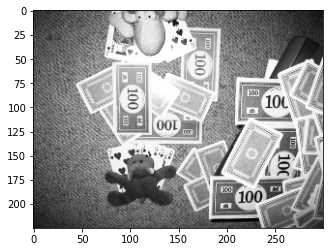

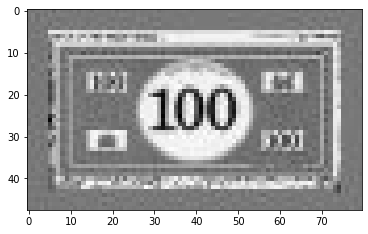

ValueError: could not broadcast input array from shape (113,150) into shape (112,150)

In [28]:
# Load query image and template 
query = cv2.imread("data/query.jpg", cv2.IMREAD_GRAYSCALE)
template = cv2.imread("data/template.jpg", cv2.IMREAD_GRAYSCALE)

# Visualize images
utils.show(query)
utils.show(template)

# Create search space and compute GHT
angles = np.linspace(0, 360, 36)
scales = np.linspace(0.9, 1.3, 10)
ght = GeneralizedHoughTransform(query, template, angles, scales)

# extract votes (correlation) and parameters
votes, thetas, s = zip(*ght)

# Visualize votes
votes = np.stack(votes).max(0)
plt.imshow(votes)
plt.show()

# nonMaxSuprression
votes = nonMaxSuprression(votes, 20)
plt.imshow(votes)
plt.show()

# Visualize n best matches
n = 10
coords = zip(*np.unravel_index(np.argpartition(votes, -n, axis=None)[-n:], votes.shape))
vis = np.stack(3*[query],2)
for y,x in coords:
    print(x,y)
    vis = cv2.circle(vis,(x,y), 10, (255,0,0), 2)
utils.show(vis)


# Test your implementation

In [21]:
import utils
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

In [22]:
from sklearn.metrics.pairwise import euclidean_distances

def testGHT():
    query = cv2.imread("data/query.jpg", cv2.IMREAD_GRAYSCALE)
    template = cv2.imread("data/template.jpg", cv2.IMREAD_GRAYSCALE)
    

    angles = np.linspace(0, 360, 36)
    scales = np.linspace(0.9, 1.3, 10)
    ght = GeneralizedHoughTransform(query, template, angles, scales)
    
    votes, thetas, s = zip(*ght)
    votes = np.stack(votes).max(0)
    plt.imshow(votes)
    plt.show()

    #votes = correlation(query, template)
    votes = nonMaxSuprression(votes, 20)
    plt.imshow(votes)
    plt.show()

    n = 10
    coords = list(zip(*np.unravel_index(np.argpartition(votes, -n, axis=None)[-n:], votes.shape)))

    vis = np.stack(3*[query],2)
    for y,x in coords:
        vis = cv2.circle(vis,(x,y), 10, (255,0,0), 2)
    utils.show(vis)

    f = open("centroids.txt", "r")
    centroids = f.read()
    f.close()
    
    centroids = centroids.split("\n")[:-1]
    centroids = [centroid.split() for centroid in centroids]
    centroids = np.array([[int(centroid[0]),int(centroid[1])] for centroid in centroids])
    
    vis = np.stack(3*[query],2)
    for x,y in centroids:
        vis = cv2.circle(vis,(x,y), 10, (255,0,0), 2)
    utils.show(vis)
    
    coords = np.array(coords)[:,::-1]

    
    d = euclidean_distances(centroids, coords).min(1)
    
    correct_detections = np.count_nonzero((d<10))
    
    score = { "scores": {"Correct_Detections": correct_detections }}
    
    print(json.dumps(score))

testGHT()

C:\Users\a\AppData\Local\Temp\ipykernel_20728\1092343753.py:160: RuntimeWarning: invalid value encountered in true_divide
  temp_i = fr / ((np.abs(fr)).sum())


ValueError: could not broadcast input array from shape (119,159) into shape (119,158)